In [1]:
!pip install torchviz

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   -------- ------------------------------- 10.2/47.1 kB ? eta -:--:--
   ---------------------------------------- 47.1/47.1 kB 784.8 kB/s eta 0:00:00
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4137 sha256=1fec181063b65740559c6f9588bfcf1724f056f04efa33dd8bbd04b1b365258e
  Stored in directory: c:\users\diana\appdata\local\pip\cache\wheels\98\f2\3d\290537e0ff7f67aa


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm import tqdm
from torchviz import make_dot
import matplotlib.pyplot as plt

In [3]:
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root = "./data", train = False, download=True, transform=transform)

100%|██████████| 26.4M/26.4M [00:05<00:00, 4.65MB/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 630kB/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:02<00:00, 1.94MB/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 9.87MB/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [4]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
train_item = next(iter(train_loader))
test_item = next(iter(test_loader))
len(train_item), len(test_item), train_item[0].shape, train_item[1].shape

(2, 2, torch.Size([64, 1, 28, 28]), torch.Size([64]))

Задача решаемая в этом ноутбуке, это классификация одежды на 10 классов из датасета FashionMNIST.
1) Прежде всего заменяем списоки self.layers и self.norm на nn.ModuleList, так как при конвертации в прод например в openvino нужны модули которые отслеживаются pytorch
2) Замена в layers_size 49 на 784, так как размерность выходного изображения 28*28


Архитектура делает следущие шаги:
1) Проходи сверткой размером (1,1), признаться честно не вижу смысла в этом действии, так как оно эквивалентно линейному слою с одинаковыми весами для всех пикселей.
2) Линейные слои, далее норализация, функция активации и дропаут
3) На выходе значения после последнего линейного слоя (in_features=16, out_features=10, bias=True). Так как задача классификации на 10 классов.

In [29]:
class NNModel(nn.Module):
    def __init__(self,
                 layers_size = [784, 32, 16, 10],
                 dropout_prob = 1.0
                 ):
        super().__init__()
        self.conv = nn.Conv2d(1, 1, kernel_size = 1, stride = 1)
        self.layers = nn.ModuleList(nn.Linear(layers_size[i], layers_size[i+1]) for i in range(len(layers_size)-1))
        self.norm = nn.ModuleList(nn.BatchNorm1d(inp_size, affine  = False) for inp_size in layers_size[1:-1])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, batch):
        bs = batch.shape[0]
        batch = self.conv(batch).reshape(bs, -1)

        for i, layer in enumerate(self.layers):
            if i < len(self.layers) -1:
                batch = self.dropout(self.relu(self.norm[i](layer(batch))))
            else:
                batch = layer(batch)
        return batch

    def print_net(self):
        print(self.conv)
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) -1:
                print(layer)
                print(self.norm[i])
                print(self.relu)
                print(self.dropout)
            else:
                print(layer)

        return

In [30]:
mlp  = NNModel(dropout_prob = 0.1)

predictions = mlp(train_item[0])
make_dot(predictions, params=dict(mlp.named_parameters()))
mlp.print_net()

Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
Linear(in_features=784, out_features=32, bias=True)
BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout(p=0.1, inplace=False)
Linear(in_features=32, out_features=16, bias=True)
BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout(p=0.1, inplace=False)
Linear(in_features=16, out_features=10, bias=True)


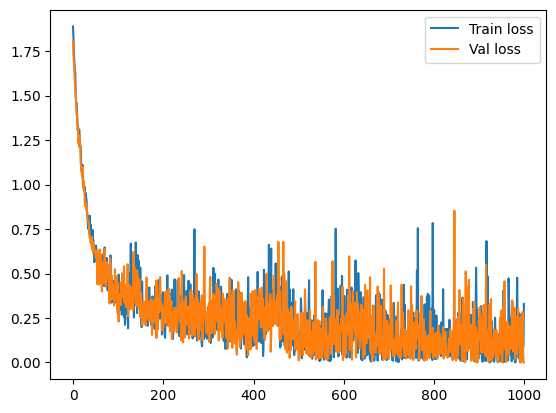

In [33]:
num_epochs = 1000
DEBUG = False
ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr =  0.01)

logger = {'train':[],
          'eval' :[]
          }
for epoch in range(num_epochs):

    epoch_stat = []

    # train part

    mlp.train()
    for batch in [train_item]:

        images, labels = batch
        images, labels = images.float(), labels.long()
        predictions = mlp(images)
        loss = ce_loss(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_stat.append(loss.item())

    if DEBUG: print(f"train loss value = {np.mean(epoch_stat)}")
    logger['train'].append(np.mean(epoch_stat))


    # eval part
    with torch.no_grad():

        eval_stat = []
        for batch in [train_item]:

            images, labels = batch
            images, labels = images.float(), labels.long()

            predictions = mlp(images)
            loss = ce_loss(predictions, labels)

            eval_stat.append(loss.item())
    if DEBUG: print(f"eval loss value = {np.mean(eval_stat)}")
    logger['eval'].append(np.mean(eval_stat))

plt.plot(logger['train'], label='Train loss' )
plt.plot(logger['eval'], label='Val loss')
plt.legend()
plt.show()

Убираем обратное распространение ошибки во время оценки модели, так как обучение не происходит. Аналогично для оптимизатора.

In [34]:
mlp

NNModel(
  (conv): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
  (norm): ModuleList(
    (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [ ]:
# pytorch_total_params = sum(p.numel() for p in mlp.parameters())
# pytorch_total_params